### EDA and Visualizations

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

# Python SQL toolkit and Object Relational Mapper dependencies.
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import psycopg2
from psycopg2 import sql, connect, Error

from config import db_password

import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
# Query to extract data from insurance_claims table in Postgres
# Code adapted from https://pynative.com/python-postgresql-select-data-from-table/

# Create a global string for the PostgreSQL db name
db_name = "insurance_fraud_db"

# Connect to an existing database
connection = psycopg2.connect(user="postgres",
                              password=db_password,
                              host="127.0.0.1",
                              port="5432",
                              database=db_name)

# Create a cursor to perform database operations
cursor = connection.cursor()

# Executing a SQL query
cursor.execute("SELECT * FROM insurance_claims")

# Fetch result
record = cursor.fetchall()

# Close connections
cursor.close()
connection.close()

In [3]:
# Query to extract column headers from insurance_claims table in Postgres
# Code adabpted from https://kb.objectrocket.com/postgresql/
# "Get The Column Names From A PostgreSQL Table with the Psycopg2 Python Adapter"

try:
    # declare a new PostgreSQL connection object
    conn = psycopg2.connect(user="postgres",
                              password=db_password,
                              host="127.0.0.1",
                              port="5432",
                              database=db_name)

except Exception as err:
    print ("psycopg2 connect() ERROR:", err)
    conn = None
    
# define a function that gets the column names from a PostgreSQL table
def get_columns_names(table):

    # declare an empty list for the column names
    columns = []

    # declare cursor objects from the connection    
    col_cursor = conn.cursor()

    # Select string for query to get column names
    col_names_str = "SELECT column_name FROM information_schema.columns WHERE table_name = 'insurance_claims' ORDER BY ordinal_position"

    try:
        sql_object = sql.SQL(
            # pass SQL statement to sql.SQL() method
            col_names_str
        ).format(
            # pass the identifier to the Identifier() method
            sql.Identifier( table )
        )

        # execute the SQL string to get list with col names in a tuple
        col_cursor.execute( sql_object )

        # get the tuple element from the liast
        col_names = ( col_cursor.fetchall() )

        # iterate list of tuples and grab first element
        for tup in col_names:

            # append the col name string to the list
            columns += [ tup[0] ]

        # close the cursor object to prevent memory leaks
        col_cursor.close()

    except Exception as err:
        print ("get_columns_names ERROR:", err)

    # return the list of column names
    return columns

# if the connection to PostgreSQL is valid
if conn != None:

    # pass a PostgreSQL string for the table name to the function
    columns = get_columns_names( "insurance_claims" )

In [4]:
# Insert data and column headers into DataFrame
insurance_df = pd.DataFrame(record, columns=columns)
insurance_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductible,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [5]:
insurance_df.shape

(1000, 39)

In [6]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   months_as_customer           1000 non-null   int64 
 1   age                          1000 non-null   int64 
 2   policy_number                1000 non-null   int64 
 3   policy_bind_date             1000 non-null   object
 4   policy_state                 1000 non-null   object
 5   policy_csl                   1000 non-null   object
 6   policy_deductible            1000 non-null   int64 
 7   policy_annual_premium        1000 non-null   object
 8   umbrella_limit               1000 non-null   int64 
 9   insured_zip                  1000 non-null   int64 
 10  insured_sex                  1000 non-null   object
 11  insured_education_level      1000 non-null   object
 12  insured_occupation           1000 non-null   object
 13  insured_hobbies              1000 

In [7]:
insurance_df.isnull().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductible              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital_gains                  0
capital_loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

In [8]:
insurance_df.dtypes

months_as_customer              int64
age                             int64
policy_number                   int64
policy_bind_date               object
policy_state                   object
policy_csl                     object
policy_deductible               int64
policy_annual_premium          object
umbrella_limit                  int64
insured_zip                     int64
insured_sex                    object
insured_education_level        object
insured_occupation             object
insured_hobbies                object
insured_relationship           object
capital_gains                   int64
capital_loss                    int64
incident_date                  object
incident_type                  object
collision_type                 object
incident_severity              object
authorities_contacted          object
incident_state                 object
incident_city                  object
incident_location              object
incident_hour_of_the_day        int64
number_of_ve

In [9]:
insurance_df.nunique()

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductible                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital_gains                   338
capital_loss                    354
incident_date                    60
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

array([[<AxesSubplot:title={'center':'months_as_customer'}>]],
      dtype=object)

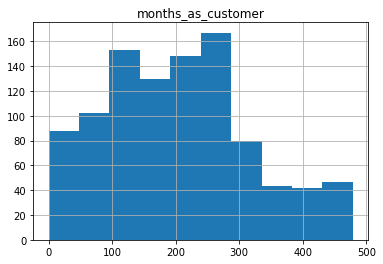

In [10]:
# Histogram of months as customer
insurance_df.hist(column='months_as_customer')

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

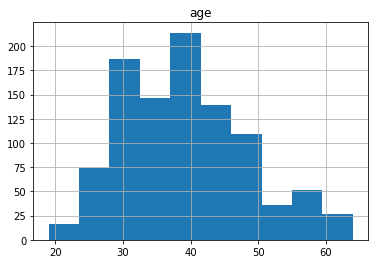

In [11]:
# Histogram of insured ages
insurance_df.hist(column='age')

array([[<AxesSubplot:title={'center':'total_claim_amount'}>]],
      dtype=object)

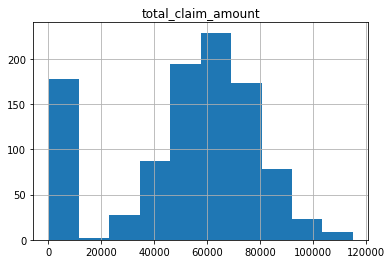

In [12]:
# Histogram of total claim amount
insurance_df.hist(column='total_claim_amount')

array([[<AxesSubplot:title={'center':'injury_claim'}>]], dtype=object)

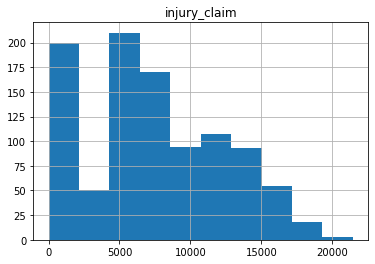

In [13]:
# Histogram of injury claims
insurance_df.hist(column='injury_claim')

array([[<AxesSubplot:title={'center':'property_claim'}>]], dtype=object)

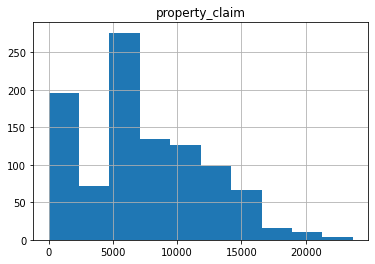

In [14]:
# Histogram of property claims
insurance_df.hist(column='property_claim')

array([[<AxesSubplot:title={'center':'vehicle_claim'}>]], dtype=object)

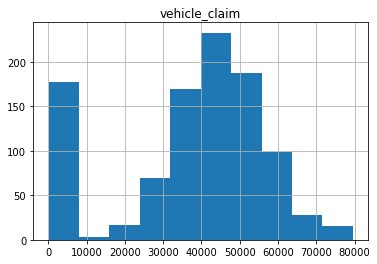

In [15]:
# Histogram of vehicle claims
insurance_df.hist(column='vehicle_claim')

<AxesSubplot:>

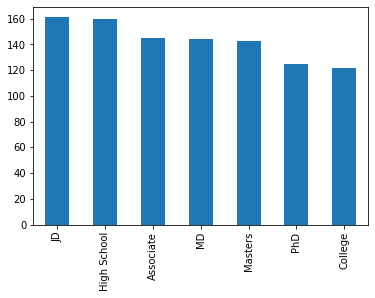

In [16]:
# Bar plot of insured education levels
insurance_df['insured_education_level'].value_counts().plot(kind='bar')

<AxesSubplot:>

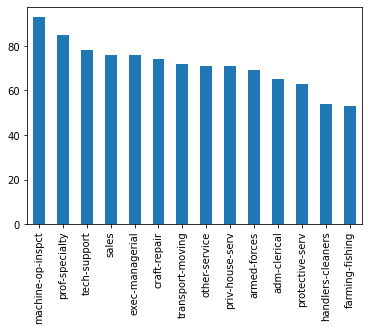

In [17]:
# Bar plot of insured education levels
insurance_df['insured_occupation'].value_counts().plot(kind='bar')

<AxesSubplot:>

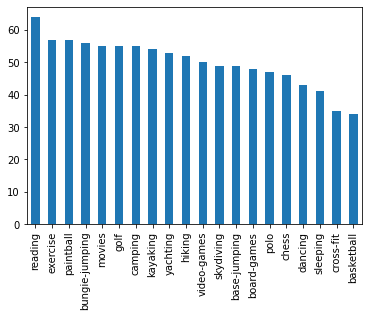

In [18]:
# Bar plot of insured hobbies
insurance_df['insured_hobbies'].value_counts().plot(kind='bar')

<AxesSubplot:>

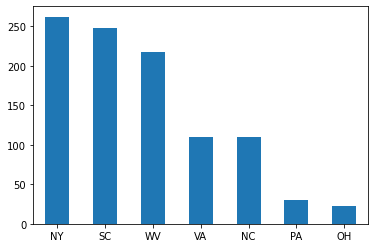

In [19]:
# Bar plot of incidet state
insurance_df['incident_state'].value_counts().plot(kind='bar', rot=0)

<AxesSubplot:>

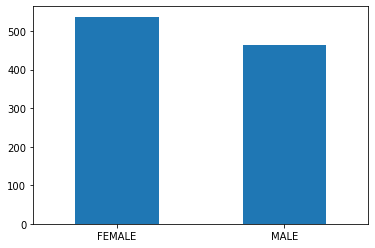

In [20]:
# Bar plot of insured sex
insurance_df['insured_sex'].value_counts().plot(kind='bar', rot=0)

<AxesSubplot:>

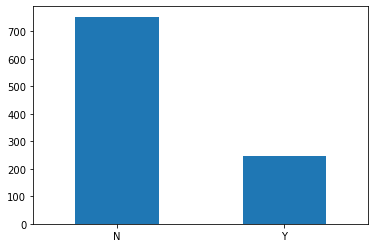

In [21]:
# Bar plot of fraud_reported column values
insurance_df['fraud_reported'].value_counts().plot(kind='bar', rot=0)